**Brian Blaylock**  
**30 January 2019**

# Does a point lie inside a contour?
This is a question I need to answer with the GOES-16 Geostationary Lightning Product and HRRR lightning product.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import multiprocessing

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon, get_hrrr_all_valid
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap, draw_GLM_map, draw_CONUS_cyl_map
from BB_GOES.get_GLM import get_GLM_file_nearesttime, accumulate_GLM, accumulate_GLM_FAST, GLM_xarray_concatenate

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15,15]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [2]:
# Get HRRR latitude and longitude grids
lat, lon = get_hrrr_latlon(DICT=False)

In [3]:
# Draw mercator projection HRRR map
mc = draw_CONUS_cyl_map()

# Draw GLM map
mg = draw_GLM_map()

# Draw HRRR basemap object
m = draw_HRRR_map()

# Draw a small domain map
m1 = draw_centermap(40, -110, size=(5.5,5.5))

# Date of interest

In [5]:
#DATE = datetime(2018, 5, 14, 22) # Mallard Fire
#DATE = datetime(2018, 7, 5, 23) # Lake Christine
#DATE = datetime(2018, 7, 17, 6) # July Storm
DATE = datetime(2018, 7, 27, 0) # Missing GLM data

## Retrieve Data

### Get HRRR

In [5]:
timer=datetime.now()

# HRRR Lightning Threat Forecasts (Analysis field is empty for lightning threat)
HH= get_hrrr_all_valid(datetime(2018, 7, 17, 6), 'LTNG:entire')

# HRRR Reflectivity Forecasts and Analysis
HHrefc = get_hrrr_all_valid(datetime(2018, 7, 17, 6), 'REFC:entire')

print('\n HRRR Download Timer:', datetime.now()-timer)


 HRRR Download Timer: 0:00:02.781252


### Get GLM
Since the HRRR lightning product is for the previous hour, we accumulate all GLM files for the 60 minutes previous to the valid time.

In [6]:
# Get GLM Data
# Since the HRRR lightning product is for the previous hour,
# accumulate all GLM files from the hour previous to the valid time.

timer=datetime.now()

files = get_GLM_file_nearesttime(DATE-timedelta(minutes=30), window=30)
g = accumulate_GLM_FAST(files)

print('\n GLM Download Timer:', datetime.now()-timer)

Looking in these file paths for the nearest datetime
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180726/22/
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180726/23/
   /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180727/00/
---------------------------------------------------
**************************************************************
!!!WARNING!!! Missing GLM directory /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180726/23/
**************************************************************
    Date Requested: 2018-07-26 23:30:00
  Nearest GLM file: 2018-07-27 00:13:40
************************************************************
!! WARNING !! There are no GLM files for the period requested!
************************************************************
************************************************************
!! WARNING !! There are no GLM files!
****************************

In [7]:
files

[]

In [11]:
np.ones_like(range(19))*np.nan

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

### Filter for GLM observations within HRRR domain

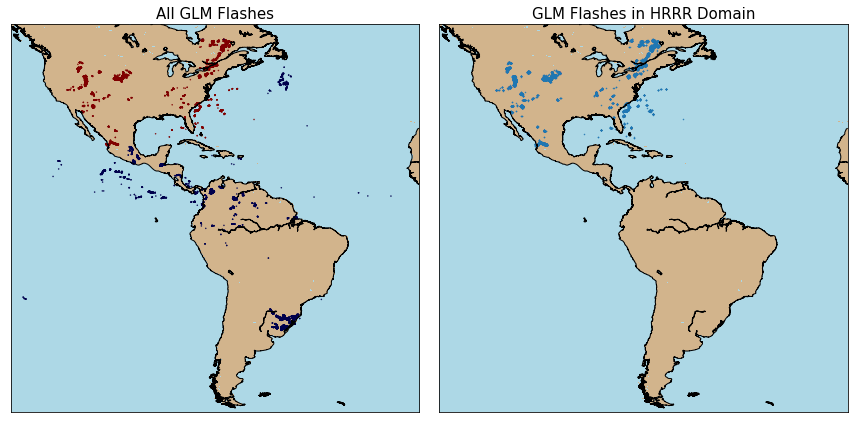

In [16]:
# Bound into HRRR domain
bound_lat = np.logical_and(g['latitude']>lat.min(), g['latitude']<lat.max())
bound_lon = np.logical_and(g['longitude']>lon.min(), g['longitude']<lon.max())
bound = np.logical_and(bound_lat, bound_lon)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,8])

plt.sca(ax1)
plt.title("All GLM Flashes")
mg.scatter(g['longitude'], g['latitude'], c=bound, marker='.', s=1, cmap='seismic')
mg.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
mg.drawcoastlines()

# Apply bounding box to GLM data
g['latitude'] = g['latitude'][bound]
g['longitude'] = g['longitude'][bound]
g['energy'] = g['energy'][bound]
g['area'] = g['area'][bound]


plt.sca(ax2)
plt.title("GLM Flashes in HRRR Domain")

mg.scatter(g['longitude'], g['latitude'],  marker='.', s=1)
mg.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
mg.drawcoastlines()


# Maps

HRRR lightning threat contours > 0 with GLM observed flash overlay for a single leadtime

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


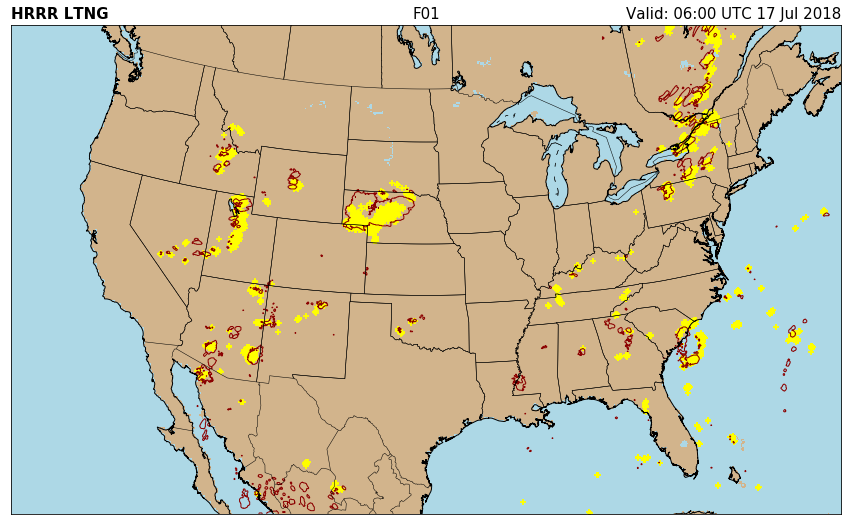

In [43]:
fxx = 1

plt.figure(figsize=(20,9))

plt.title('HRRR LTNG', loc='left', fontweight='semibold')
plt.title('F%02d' % fxx)
plt.title('Valid: %s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right')

#m.pcolormesh(lon, lat, HH[fxx], latlon=True)
m.scatter(g['longitude'], g['latitude'], marker='+', c='yellow', latlon=True)
m.contour(lon, lat, HH[fxx].data, levels=[0], latlon=True, linewidths=1, colors='darkred')

m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
m.drawcountries()
m.drawstates()
m.drawcoastlines()

All lightning threat contours and model spread

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


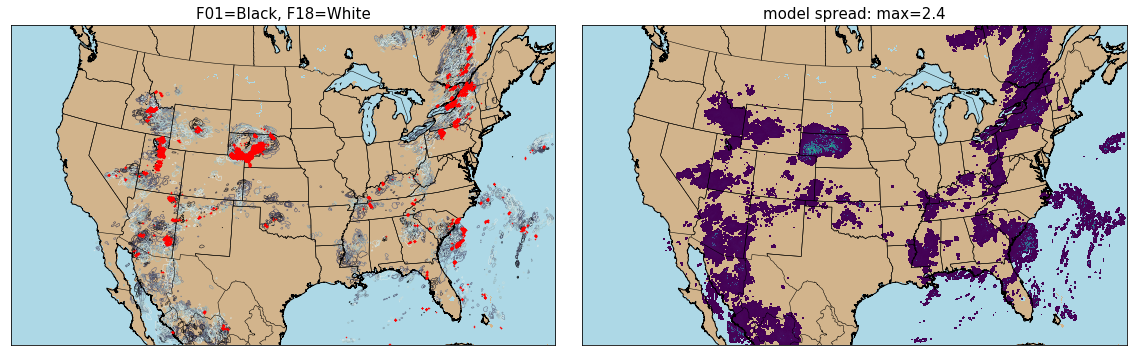

In [45]:
# Show Contours on HRRR CONUS Plot

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[20,8])

plt.sca(ax1)
plt.title('F01=Black, F18=White')
# Generate a list of colors
cmap = mpl.cm.get_cmap('bone')
colors = cmap(np.arange(len(HH[1:]))/19)

for i, H in enumerate(HH[1:]):
    m.contour(lon, lat, H.data, latlon=True, levels=[0], zorder=1, linewidths=.5, colors=[colors[i]])

s = m.scatter(g['longitude'], g['latitude'], marker='.', c='red', zorder=10, latlon=True, s=1)

m.drawlsmask(land_color='tan', ocean_color='lightblue', lakes=True)
m.drawcountries()
m.drawstates()
m.drawcoastlines()


plt.sca(ax2)
# Model spread canot be calculated from masked arrays. Need to use all data becuase zeros are needed in std calculation
data = np.std(HH[1:].data, ddof=1, axis=0)
# Now that std is computed, now we can mask anything less than 0...
data = np.ma.array(data, mask=data<=0)

plt.title('model spread: max=%.1f' % data.max())
m.pcolormesh(lon, lat, data, latlon=True, vmin=0)

m.drawlsmask(land_color='tan', ocean_color='lightblue', lakes=True)
m.drawcountries()
m.drawstates()
m.drawcoastlines()

# Create Contour Collections Objects
We can `matplotlib.pyplot.contour()` to generate Paths for each contour area. These paths can be used to determine if a GLM flash occured within the HRRR forecasted lightning threat area.

NOTE: We must generate the collections with a cylindrical map projection, else contour returns funny map coordinates for the verticies of the path.

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4995: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  elif masked and is_scalar(masked):


Text(0.5,1,'F01=Black, F18=White')

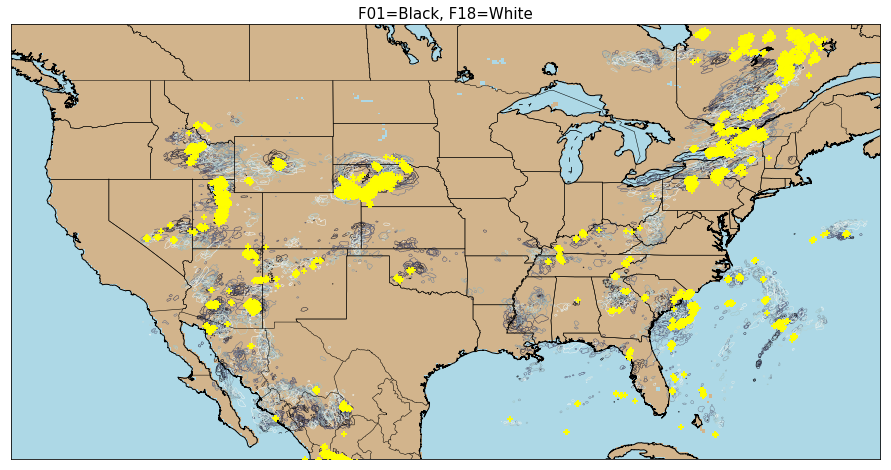

In [46]:
# Generate Contour Objects
fig, ax1 = plt.subplots(figsize=[20,8])

# Generate a list of colors
cmap = mpl.cm.get_cmap('bone')
colors = cmap(np.arange(len(HH))/19)

# ! We have to create the contour objects with a cylindrical projection so that the points are in lat/lon coordinates and not map coordinates
CONTOURS = []
for i, H in enumerate(HH):
    c = mc.contour(lon, lat, H.data, latlon=True, levels=[0], zorder=1, linewidths=.5, colors=[colors[i]])
    CONTOURS.append(c)

s = mc.scatter(g['longitude'], g['latitude'], marker='+', c='yellow', zorder=10)

mc.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
mc.drawcountries()
mc.drawstates()
mc.drawcoastlines()

plt.title('F01=Black, F18=White')

# Determine which GLM flash occurred in a HRRR contour

In [48]:
def points_inside_contours_MP(inputs):
    """
    Input: [lat, lon, COLLECTIONS, level]
        lat        - list of GLM observed latitudes
        lon        - list of GLM observed longitudes
        COLLECTION - a matplotlib.contour.QuadContourSet object from plt.contour()
        level      - contour level. Usually set to 0 for first contour level.
    """
    lat, lon, COLLECTION, level = inputs
    
    # Initialize an array to store when points are instide a collection
    inside = np.zeros_like(lat)
    
    # Combine the lat/lon points into a tuple pair
    latlon_pair = [(lon[i], lat[i]) for i in range(len(lat))]
    
    # Each collection may have many paths--a path for each contour area.
    # We need to loop through each area and find out which points
    # lie inside the area. Those points that inside the path area (True),
    # Then we add those to the inside array.
    num = len(COLLECTION.collections[level].get_paths())
    for i, V in enumerate(COLLECTION.collections[level].get_paths()):
        is_inside = V.contains_points(latlon_pair)
        inside += is_inside
        sys.stdout.write('\r%.1f%% Complete (%s of %s)' % ((i+1)/num*100, (i+1), num))
    
    # Convert the inside array to a boolean. This boolean
    # matches the lat/lon points in the same order.
    return np.array(inside, dtype=bool)
    
    
def points_inside_contours(lat, lon, COLLECTIONS, level=0):
    """
    lat         - list of latitudes
    lon         - list of longitudes
    COLLECTIONS - list of contour collections; matplotlib.contour.QuadContourSet 
    level       - contour level index, usually zero.
    """
    # GLM Latitude, GLM Longitude, Contour Collection, Contour Level Index
    timer = datetime.now()
    inputs = [[lat, lon, C, 0] for i, C in enumerate(COLLECTIONS)]
    cores = np.minimum(multiprocessing.cpu_count(), len(inputs))
    with multiprocessing.Pool(cores) as p:
        a = np.array(p.map(points_inside_contours_MP, inputs))
        p.close()
        p.join()
    print('\n', datetime.now()-timer)
    return a

In [49]:
# An array for each forecast lead time
inside = points_inside_contours(g['latitude'], g['longitude'], CONTOURS)

100.0% Complete (170 of 170)
 0:00:11.681717


In [58]:
# Shape of the inside data
print(np.shape(inside))

# Percentage of flashes in HRRR contour
perc = np.array([sum(i)/len(i) for ii, i in enumerate(inside)])

for i, p in enumerate(perc):
    print('F%02d: %.2f%%' % (i, p))

(19, 19337)
F00: 0.00%
F01: 0.58%
F02: 0.49%
F03: 0.36%
F04: 0.37%
F05: 0.38%
F06: 0.35%
F07: 0.44%
F08: 0.42%
F09: 0.37%
F10: 0.20%
F11: 0.24%
F12: 0.29%
F13: 0.08%
F14: 0.14%
F15: 0.16%
F16: 0.23%
F17: 0.43%
F18: 0.45%


Text(0.5,0,'Forecast Lead time (hours)')

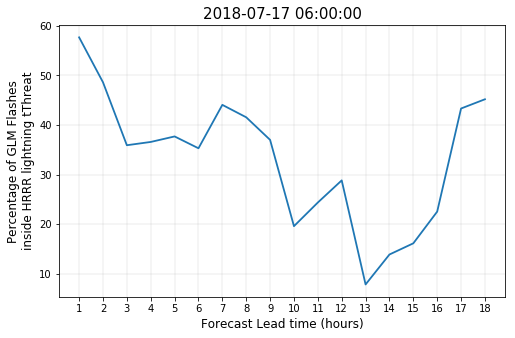

In [66]:
plt.figure(figsize=[8,5])
plt.plot(range(1,19), np.array(perc[1:])*100)
plt.xticks(range(1,19));
plt.grid()

plt.title(DATE)
plt.ylabel('Percentage of GLM Flashes\ninside HRRR lightning tThreat')
plt.xlabel('Forecast Lead time (hours)')

HRRR lightning and simulated reflectivity

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


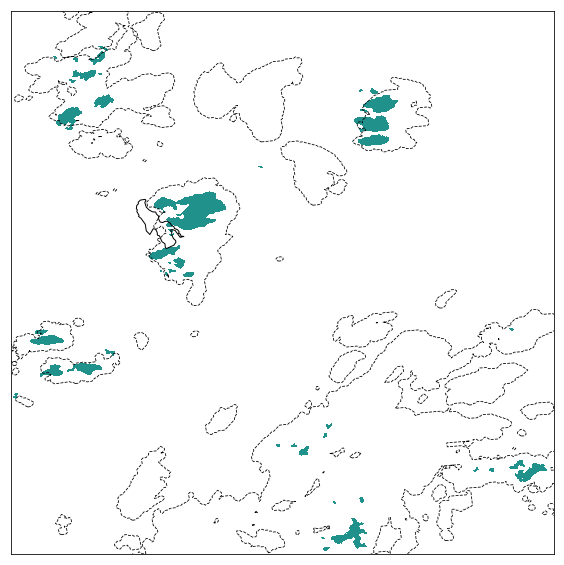

In [522]:
plt.figure(figsize=[10,10])
#m.contour(lon, lat, HH[1].data, levels=[0], latlon=True)
m1.contourf(lon, lat, HH[1], levels=[0,1000], latlon=True)
#m.scatter(g['longitude'], g['latitude'], latlon=True, s=1, c='r')

m1.contour(lon, lat, HHrefc[1].data, levels=[-10], colors='k', latlon=True, linewidths=.8)

m1.drawcoastlines()

Map of HRRR lightning and flashes inside/outside for each forecast hour

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


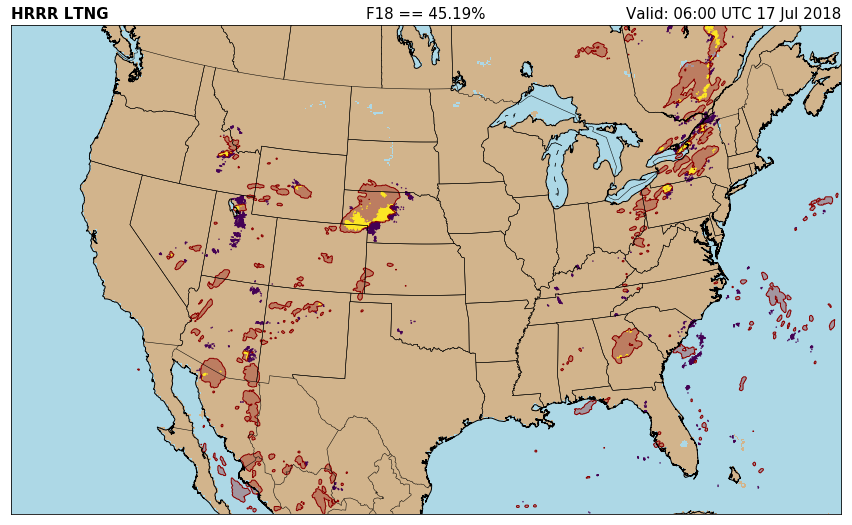

In [91]:
fxx = 18

plt.figure(figsize=[20,9])


m.contourf(lon, lat, HH[fxx], levels=[0,1000], colors='darkred', latlon=True, alpha=.3)

m.scatter(g['longitude'], g['latitude'], c=inside[fxx], latlon=True, marker='.', s=1)

m.contour(lon, lat, HH[fxx].data, levels=[0], colors='darkred', latlon=True, linewidths=1)

m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
m.drawcoastlines()
m.drawstates()
m.drawcountries()

plt.title('HRRR LTNG', loc='left', fontweight='semibold');
plt.title('F%02d == %.2f%%' % (fxx, np.array(perc[fxx])*100));
plt.title('Valid: %s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right');

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


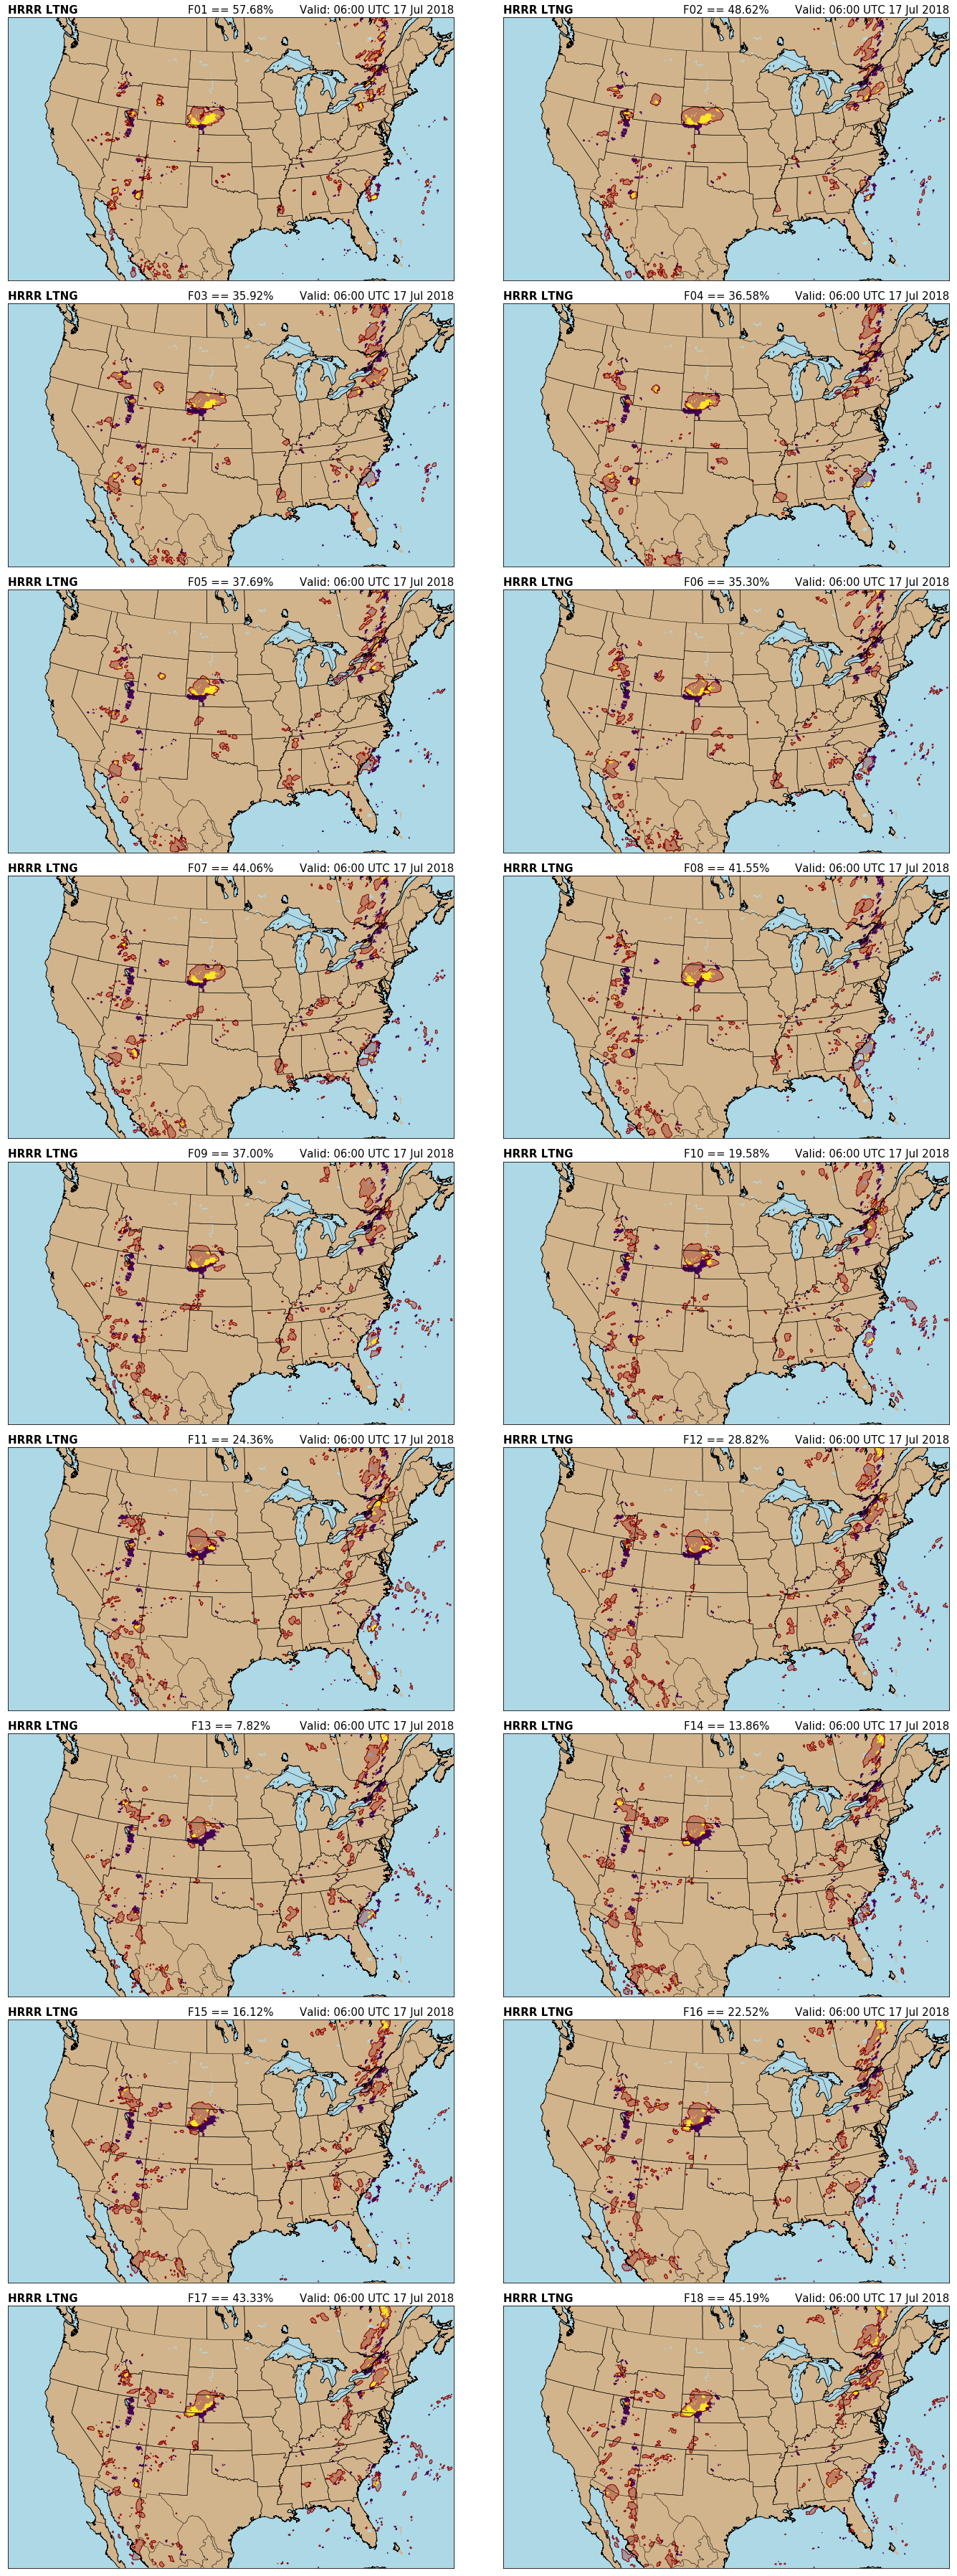

In [100]:
fig, axes = plt.subplots(9, 2, figsize=[20,50])
axes = axes.flatten()

for i, ax in enumerate(axes):
    fxx = i+1
    plt.sca(ax)
    m.contourf(lon, lat, HH[fxx], levels=[0,1000], colors='darkred', latlon=True, alpha=.3)
    m.scatter(g['longitude'], g['latitude'], c=inside[fxx], latlon=True, marker='.', s=1)
    m.contour(lon, lat, HH[fxx].data, levels=[0], colors='darkred', latlon=True, linewidths=1)
    
       
    m.drawlsmask(land_color='tan',ocean_color='lightblue',lakes=True)
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    
    plt.title('HRRR LTNG', loc='left', fontweight='semibold');
    plt.title('F%02d == %.2f%%' % (fxx, np.array(perc[fxx])*100));
    plt.title('Valid: %s' % DATE.strftime('%H:%M UTC %d %b %Y'), loc='right');
    
plt.tight_layout()